In [115]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC ,
                          DecisionTreeRegressor as DTR ,
                          plot_tree ,
                          export_text)
from sklearn.metrics import (accuracy_score ,
                             log_loss)
from sklearn.ensemble import \
    (RandomForestRegressor as RF ,
     GradientBoostingRegressor as GBR)
from ISLP.bart import BART

Fitting Classification Trees

In [116]:
Carseats = load_data("Carseats")
High = np.where(Carseats.Sales > 8, "Yes", "No")
model = MS(Carseats.columns.drop("Sales"), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

clf = DTC(criterion="entropy", max_depth =3, random_state =0)
clf.fit(X, High)

accuracy_score(High , clf.predict(X))

0.79

In [117]:
resid_dev = np.sum(log_loss(High , clf.predict_proba(X)))
resid_dev

0.4710647062649358

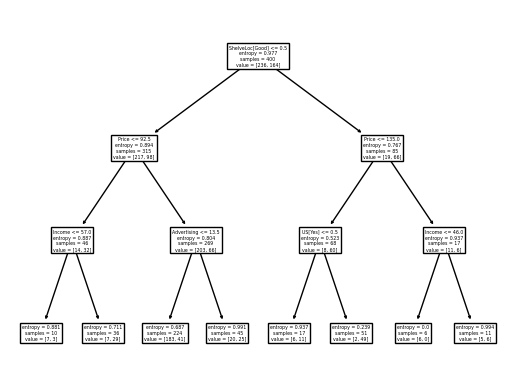

In [118]:
plot_tree(clf , feature_names=feature_names);

In [119]:
validation = skm.ShuffleSplit(n_splits =1, test_size =200, random_state =0)
results = skm.cross_validate(clf , D , High , cv=validation)
results["test_score"]

array([0.685])

In [120]:
(X_train , X_test , High_train , High_test) = skm.train_test_split(X, High , test_size =0.5, random_state =0)

clf = DTC(criterion="entropy", random_state =0)
clf.fit(X_train , High_train)
accuracy_score(High_test , clf.predict(X_test))

0.735

In [121]:
ccp_path = clf.cost_complexity_pruning_path(X_train , High_train)
kfold = skm.KFold (10, random_state =1, shuffle=True)

grid = skm.GridSearchCV(clf , {"ccp_alpha": ccp_path.ccp_alphas}, refit=True , cv=kfold , scoring="accuracy")
grid.fit(X_train , High_train)
grid.best_score_

0.685

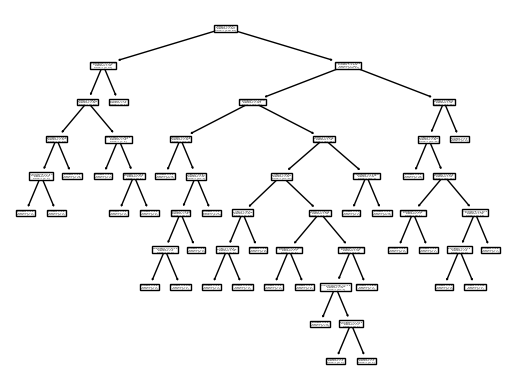

In [122]:
best_ = grid.best_estimator_

plot_tree(best_ , feature_names=feature_names);

In [123]:
print(accuracy_score(High_test , best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


Fitting Regression Trees

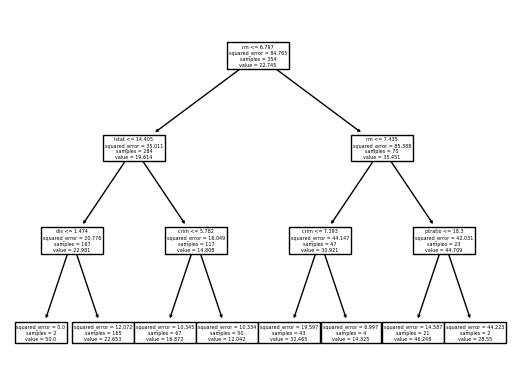

In [124]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop("medv"), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

(X_train , X_test , y_train , y_test) = skm.train_test_split(X, Boston["medv"], test_size =0.3, random_state =0)

reg = DTR(max_depth =3)
reg.fit(X_train , y_train)

plot_tree(reg , feature_names=feature_names);

In [125]:
ccp_path = reg.cost_complexity_pruning_path(X_train , y_train)
kfold = skm.KFold(5, shuffle=True , random_state =10)
grid = skm.GridSearchCV(reg , {"ccp_alpha": ccp_path.ccp_alphas}, refit=True , cv=kfold , scoring="neg_mean_squared_error")
G = grid.fit(X_train , y_train)

best_ = grid.best_estimator_
np.mean(( y_test - best_.predict(X_test))**2)

28.069857549754044

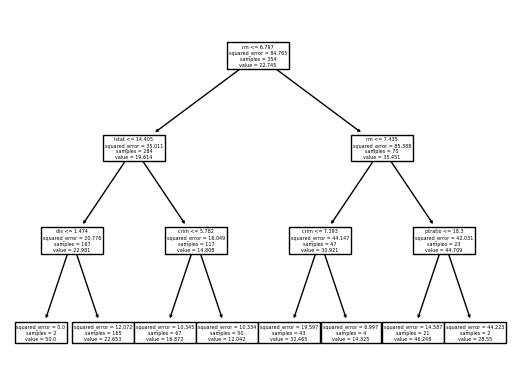

In [126]:
plot_tree(G.best_estimator_ , feature_names=feature_names);

Bagging and Random Forests

14.634700151315787

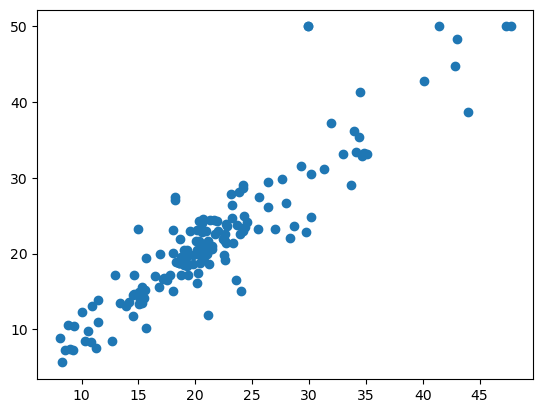

In [127]:
bag_boston = RF(max_features=X_train.shape [1], random_state =0)
bag_boston.fit(X_train , y_train)

ax = subplots()[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag , y_test)
np.mean(( y_test - y_hat_bag)**2)

In [128]:
bag_boston = RF(max_features=X_train.shape [1], n_estimators =500, random_state =0).fit(X_train , y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean(( y_test - y_hat_bag)**2)

14.605662565263161

In [129]:
RF_boston = RF(max_features =6, random_state =0).fit(X_train , y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean(( y_test - y_hat_RF)**2)

20.04276446710527

In [130]:
feature_imp = pd.DataFrame({"importance":RF_boston.feature_importances_}, index=feature_names)
feature_imp.sort_values(by="importance", ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


Boosting

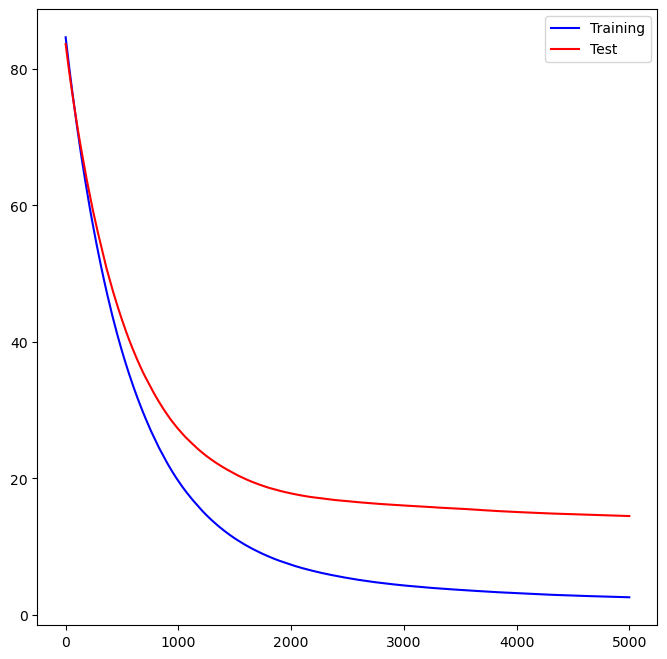

In [131]:
boost_boston = GBR(n_estimators =5000 , learning_rate =0.001 , max_depth =3, random_state =0)
boost_boston.fit(X_train , y_train)

test_error = np.zeros_like(boost_boston.train_score_)

for idx , y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean(( y_test - y_)**2)
    
plot_idx = np.arange(boost_boston.train_score_.shape [0])
ax = subplots(figsize =(8 ,8))[1]
ax.plot(plot_idx , boost_boston.train_score_ , "b", label="Training")
ax.plot(plot_idx , test_error , "r", label="Test")
ax.legend ();

In [132]:
y_hat_boost = boost_boston.predict(X_test);
np.mean(( y_test - y_hat_boost)**2)

14.481405918831591

In [133]:
boost_boston = GBR(n_estimators =5000 , learning_rate =0.2, max_depth =3,random_state =0)
boost_boston.fit(X_train , y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean(( y_test - y_hat_boost)**2)

14.501514553719565